In [2]:
from qiskit import BasicAer, Aer, IBMQ
from qiskit.aqua.algorithms import VQE, NumPyEigensolver
from qiskit.aqua.components.optimizers import SLSQP, COBYLA, L_BFGS_B, NFT, ADAM
from qiskit.aqua.operators import Z2Symmetries

from qiskit.chemistry import FermionicOperator
from qiskit.chemistry.drivers import PySCFDriver, UnitsType
from qiskit.chemistry.components.variational_forms import UCCSD
from qiskit.chemistry.components.initial_states import HartreeFock

from qiskit.providers.aer import QasmSimulator

provider = IBMQ.load_account()

import datetime
import numpy as np
import matplotlib.pyplot as plt

/opt/conda/lib/python3.7/site-packages/qiskit/providers/ibmq/ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


In [3]:
import warnings;
warnings.filterwarnings('ignore');

In [4]:
# From Qiskit textbook - I am not brave enough to mess with this :/
def get_qubit_op(dist):
    driver = PySCFDriver(atom="Li .0 .0 .0; H .0 .0 " + str(dist), unit=UnitsType.ANGSTROM, 
                         charge=0, spin=0, basis='sto3g')
    molecule = driver.run()
    freeze_list = [0]
    remove_list = [-3, -2]
    repulsion_energy = molecule.nuclear_repulsion_energy
    num_particles = molecule.num_alpha + molecule.num_beta
    num_spin_orbitals = molecule.num_orbitals * 2
    remove_list = [x % molecule.num_orbitals for x in remove_list]
    freeze_list = [x % molecule.num_orbitals for x in freeze_list]
    remove_list = [x - len(freeze_list) for x in remove_list]
    remove_list += [x + molecule.num_orbitals - len(freeze_list)  for x in remove_list]
    freeze_list += [x + molecule.num_orbitals for x in freeze_list]
    ferOp = FermionicOperator(h1=molecule.one_body_integrals, h2=molecule.two_body_integrals)
    ferOp, energy_shift = ferOp.fermion_mode_freezing(freeze_list)
    num_spin_orbitals -= len(freeze_list)
    num_particles -= len(freeze_list)
    ferOp = ferOp.fermion_mode_elimination(remove_list)
    num_spin_orbitals -= len(remove_list)
    qubitOp = ferOp.mapping(map_type='parity', threshold=0.00000001)
    qubitOp = Z2Symmetries.two_qubit_reduction(qubitOp, num_particles)
    shift = energy_shift + repulsion_energy
    return qubitOp, num_particles, num_spin_orbitals, shift

# Does NOT account for two orbitals in LiH
# What is the difference between freezing and removing orbitals in the driver?

In [5]:
# Generating bond energy curves with different optimizers
distances = np.arange(0.5, 4.0, 0.1)
optimizers = {
    "SLSQP":SLSQP(maxiter=5),
    "COBYLA":COBYLA(maxiter=500, disp=False, rhobeg=1.0, tol=0.2),
    "L_BFGS_B":L_BFGS_B(maxfun=250,maxiter=3750,factr=1e3,iprint=-1,epsilon=1e-09),
    "NFT":NFT(maxiter=64, maxfev=64,disp=False,reset_interval=32),
    "ADAM":ADAM(maxiter=125, tol=1e-02, lr=0.1, beta_1=0.9, beta_2=0.9, noise_factor=1e-08, eps=1e-7, amsgrad=False, snapshot_dir=None)
}
#optimizers = {"COBYLA":COBYLA(maxiter=500, disp=False, rhobeg=1.0, tol=0.2)}

In [6]:
# Statevector simulator run
backend = BasicAer.get_backend("statevector_simulator")
exact_energies = []
vqe_energies = [[] for i in range(len(optimizers))]
vqe_result = []
converge_itrs = [[] for i in range(len(optimizers))]
converge_vals = [[] for i in range(len(optimizers))]
converge_stdevs = [[] for i in range(len(optimizers))]
itrs = []
vals = []
stdevs = []

def get_eval_result(num_eval, params, mean, std):
    itrs.append(num_eval)
    vals.append(mean)
    stdevs.append(std)

n = 0
ct = datetime.datetime.now()
print("Start - ",ct)
for opt in optimizers:
    for dist in distances:
        #print(dist,' ') # Why is this not iterating with fixed width?
        qubitOp, num_particles, num_spin_orbitals, shift = get_qubit_op(dist)
        if n == 0:
            result = NumPyEigensolver(qubitOp).run()
            exact_energies.append(np.real(result.eigenvalues) + shift)
        initial_state = HartreeFock(
            num_spin_orbitals,
            num_particles,
            qubit_mapping='parity'
        ) 
        var_form = UCCSD(
            num_orbitals=num_spin_orbitals,
            num_particles=num_particles,
            initial_state=initial_state,
            qubit_mapping='parity'
        )

        # quality bush fix, lol
        if round(dist,2) == 1.6:
            vqe = VQE(qubitOp, var_form, optimizers[opt],callback=get_eval_result)
            vqe_result = np.real(vqe.run(backend)['eigenvalue'] + shift)
            vqe_energies[n].append(vqe_result)
            # store eval data only at equilibrium bond length
            converge_itrs[n] = itrs
            converge_vals[n] = vals
            converge_stdevs[n] = stdevs
            itrs = []
            vals = []
            stdevs = []
        else:
            vqe = VQE(qubitOp, var_form, optimizers[opt])
            vqe_result = np.real(vqe.run(backend)['eigenvalue'] + shift)
            vqe_energies[n].append(vqe_result)
    n += 1
    ct = datetime.datetime.now()
    print(opt,"Finish - ",ct)
    
print("VQE Complete")

Start -  2020-12-03 14:20:25.675933
SLSQP Finish -  2020-12-03 14:23:47.188282
COBYLA Finish -  2020-12-03 14:26:21.656599
L_BFGS_B Finish -  2020-12-03 14:30:47.136476
NFT Finish -  2020-12-03 14:34:09.170116
ADAM Finish -  2020-12-03 14:46:29.586652
VQE Complete


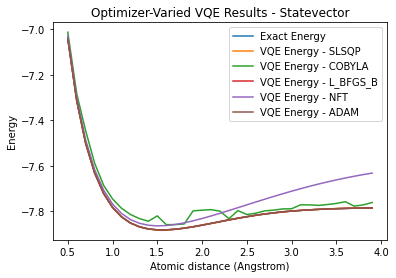

In [7]:
plt.plot(distances, exact_energies, label="Exact Energy")
opt_labels = ["SLSQP","COBYLA","L_BFGS_B","NFT","ADAM"]
#opt_labels = ["COBYLA"] # debugging
for i in range(len(opt_labels)):
    plt.plot(distances, vqe_energies[i], label="VQE Energy - %s" % (opt_labels[i]))
plt.xlabel('Atomic distance (Angstrom)')
plt.ylabel('Energy')
plt.title('Optimizer-Varied VQE Results - Statevector')
plt.legend()
plt.show()

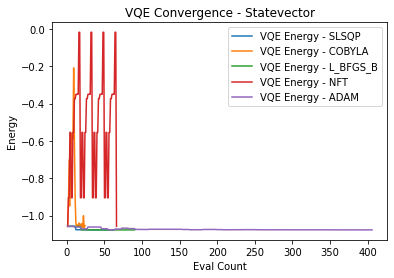

In [8]:
opt_labels = ["SLSQP","COBYLA","L_BFGS_B","NFT","ADAM"]
#opt_labels = ["COBYLA"] # debugging
for i in range(len(opt_labels)):
    plt.plot(converge_itrs[i], converge_vals[i], label="VQE Energy - %s" % (opt_labels[i]))
plt.xlabel('Eval Count')
plt.ylabel('Energy')
plt.title('VQE Convergence - Statevector')
plt.legend()
plt.show()

In [9]:
# QASM simulator version of above - extreme slowdown!!
backend = BasicAer.get_backend("qasm_simulator")
exact_energies = []
vqe_energies = [[] for i in range(len(optimizers))]
vqe_result = []
converge_itrs = [[] for i in range(len(optimizers))]
converge_vals = [[] for i in range(len(optimizers))]
converge_stdevs = [[] for i in range(len(optimizers))]
itrs = []
vals = []
stdevs = []

n = 0
ct = datetime.datetime.now()
print("Start - ",ct)
for opt in optimizers:
    for dist in distances:
        qubitOp, num_particles, num_spin_orbitals, shift = get_qubit_op(dist)
        if n == 0:
            result = NumPyEigensolver(qubitOp).run()
            exact_energies.append(np.real(result.eigenvalues) + shift)
        initial_state = HartreeFock(
            num_spin_orbitals,
            num_particles,
            qubit_mapping='parity'
        ) 
        var_form = UCCSD(
            num_orbitals=num_spin_orbitals,
            num_particles=num_particles,
            initial_state=initial_state,
            qubit_mapping='parity'
        )

        if round(dist,2) == 1.6:
            vqe = VQE(qubitOp, var_form, optimizers[opt],callback=get_eval_result)
            vqe_result = np.real(vqe.run(backend)['eigenvalue'] + shift)
            vqe_energies[n].append(vqe_result)
            # store eval data only at equilibrium bond length
            converge_itrs[n] = itrs
            converge_vals[n] = vals
            converge_stdevs[n] = stdevs
            itrs = []
            vals = []
            stdevs = []
        else:
            vqe = VQE(qubitOp, var_form, optimizers[opt])
            vqe_result = np.real(vqe.run(backend)['eigenvalue'] + shift)
            vqe_energies[n].append(vqe_result)
    n += 1
    ct = datetime.datetime.now()
    print(opt,"Finish - ",ct)
    
print("VQE Complete")

Start -  2020-12-03 14:49:41.523859
SLSQP Finish -  2020-12-03 15:11:39.304859
COBYLA Finish -  2020-12-03 15:32:12.720851
L_BFGS_B Finish -  2020-12-03 18:30:36.463388
NFT Finish -  2020-12-03 19:20:44.532725
ADAM Finish -  2020-12-04 08:49:03.249624
VQE Complete


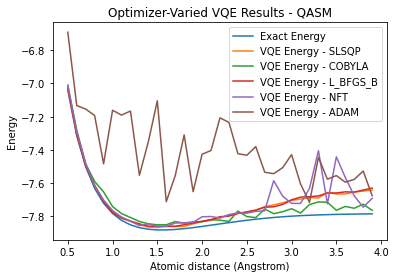

In [10]:
plt.plot(distances, exact_energies, label="Exact Energy")
opt_labels = ["SLSQP","COBYLA","L_BFGS_B","NFT","ADAM"]
for i in range(len(opt_labels)):
    plt.plot(distances, vqe_energies[i], label="VQE Energy - %s" % (opt_labels[i]))
plt.xlabel('Atomic distance (Angstrom)')
plt.ylabel('Energy')
plt.title('Optimizer-Varied VQE Results - QASM')
plt.legend()
plt.show()

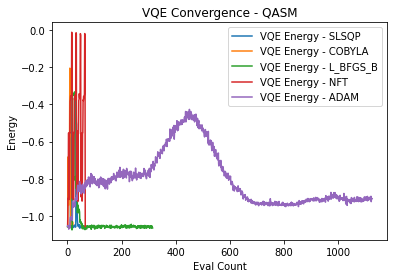

In [11]:
opt_labels = ["SLSQP","COBYLA","L_BFGS_B","NFT","ADAM"]
for i in range(len(opt_labels)):
    plt.plot(converge_itrs[i], converge_vals[i], label="VQE Energy - %s" % (opt_labels[i]))
plt.xlabel('Eval Count')
plt.ylabel('Energy')
plt.title('VQE Convergence - QASM')
plt.legend()
plt.show()